### CIFAR100数据集可视化

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as  transforms
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchsummary import summary
from torch.autograd import Variable
import time as time
import numpy as np  
import os  
import pickle as pickle  
import glob  
import matplotlib.pyplot as plt  
import albumentations as alb
import warnings
warnings.filterwarnings('ignore')

In [4]:
train = datasets.CIFAR100(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test = datasets.CIFAR100(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

0it [00:00, ?it/s]

Files already downloaded and verified


In [16]:
def swapaxes(a):
    a = a.swapaxes(0, 1).swapaxes(1, 2)
    return a
img = []
for i in range(32):
    img.append(swapaxes(train[i][0]))

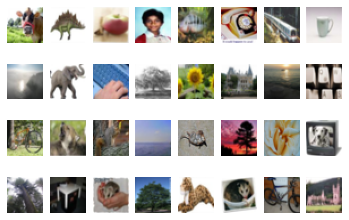

In [18]:
plt.figure()
for i in range(1,33):
    plt.subplot(4,8,i)
    plt.imshow(img[i-1])
    plt.axis('off')
plt.show()

### 数据增强效果

In [79]:
def tensor_to_PIL(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    unloader = transforms.ToPILImage()
    image = unloader(image)
    return image

In [39]:
mean = (0.4913997551666284, 0.48215855929893703, 0.4465309133731618)
std = (0.24703225141799082, 0.24348516474564, 0.26158783926049628)

In [80]:
train_transform = alb.Compose([
    alb.Resize(32, 32, always_apply=True),
    alb.Normalize(mean, std, always_apply=True),
    alb.HorizontalFlip(p=0.1),
    alb.RandomBrightness(p=0.2),
    alb.RandomContrast(p=0.1),
    alb.RGBShift(p=0.1),
    alb.GaussNoise(p=0.1),
])

In [117]:
img_alb = []
for i in range(32):
    image = np.array(tensor_to_PIL(train[i][0]))
    image = train_transform(image= image)['image']
    image = torch.tensor(image, dtype=torch.float)
    image = image.permute(2, 0, 1)
    img_alb.append(swapaxes(image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

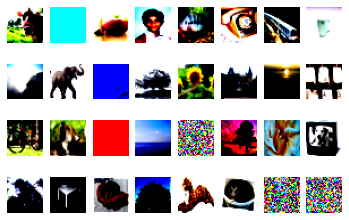

In [119]:
plt.figure()
for i in range(1,33):
    plt.subplot(4,8,i)
    plt.imshow(img_alb[i-1])
    plt.axis('off')
plt.show()

### ViT网络数据可视化

In [5]:
def net_info(model):
    data_input = Variable(torch.randn(8,3,32,32))
    model(data_input)
    print(summary(model,(3,32,32)))

In [3]:
class SelfAttention(nn.Module):
    def __init__(
        self,
        embedding_dims,
        heads,
        dropout
    ):
        super(SelfAttention, self).__init__()
        self.heads = heads
        self.embedding_dims = embedding_dims
        self.head_dims = int(embedding_dims/heads)

        self.key = nn.Linear(self.head_dims, self.head_dims)
        self.query = nn.Linear(self.head_dims, self.head_dims)
        self.value = nn.Linear(self.head_dims, self.head_dims)

        self.fc = nn.Linear(self.head_dims*self.heads, self.embedding_dims)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, query, key, value, mask):
        Batch = query.shape[0]

        query_len, key_len, value_len = query.shape[1], key.shape[1], value.shape[1]

        query = query.reshape(Batch, query_len, self.heads, self.head_dims)
        key = key.reshape(Batch, key_len, self.heads, self.head_dims)
        value = value.reshape(Batch, value_len, self.heads, self.head_dims)

        query = self.query(query)
        key = self.key(key)
        value = self.value(value)

        attention_score = torch.einsum('bqhd,bkhd->bhqk', [query, key])

        if mask is not None:
            attention_score = attention_score.masked_fill(mask==0, float('-1e20'))

        attention_score = attention_score/((self.head_dims)**(1/2))
        attention_score = torch.softmax(attention_score, dim=-1)

        out = torch.einsum('bhqv,bvhd->bqhd', [attention_score, value]).reshape(
            Batch, query_len, self.heads*self.head_dims
        )

        out = self.dropout(self.fc(out))

        return out



class TransformerBlock(nn.Module):
    def __init__(
        self,
        embedding_dims,
        heads,
        dropout, 
        forward_expansion,
        layer_norm_eps
    ):
        super(TransformerBlock, self).__init__()
        self.layer_norm1 = nn.LayerNorm(embedding_dims, eps=layer_norm_eps)
        self.layer_norm2 = nn.LayerNorm(embedding_dims, eps=layer_norm_eps)
        self.attention = SelfAttention(embedding_dims, heads, dropout)
        self.feed_forward = nn.Sequential(
                nn.Linear(embedding_dims, embedding_dims*forward_expansion),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(embedding_dims*forward_expansion, embedding_dims),
                nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask):
        norm = self.layer_norm1(x)
        attention_block = self.attention(norm, norm, norm, mask)
        add = x + attention_block
        norm = self.layer_norm2(add)
        feed_forward = self.feed_forward(norm)
        out = feed_forward + add
        return out


class ViT(nn.Module):
    def __init__(
        self,
        patch_height,
        patch_width,
        max_len,
        embedding_dims,
        heads,
        forward_expansion,
        num_layers,
        dropout,
        layer_norm_eps,
        num_classes
    ):
        super(ViT, self).__init__()
        
        self.vit_blocks = nn.Sequential(
            *[
                TransformerBlock(
                    embedding_dims,
                    heads,
                    dropout,
                    forward_expansion,
                    layer_norm_eps
                )
                for _ in range(num_layers)
            ]
            
        )
        self.patch_height = patch_height
        self.patch_width = patch_width
        self.cls_embedding = nn.Parameter(torch.zeros(1, 1, embedding_dims))
        self.patch_embeddings = nn.Linear(embedding_dims, embedding_dims)
        self.postional_embedding = nn.Parameter(torch.zeros(1, max_len, embedding_dims))
        self.to_cls_token = nn.Identity()
        self.classifier = nn.Sequential(
            nn.LayerNorm(embedding_dims),
            nn.Linear(embedding_dims, num_classes*4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(num_classes*4, num_classes)
        )
        self.dropout = nn.Dropout(dropout)


    def forward(self, images):
        patches = images.unfold(2, self.patch_height, self.patch_width)
        patches = patches.unfold(3, self.patch_height, self.patch_width)
        patches = patches.permute(0, 2, 3, 1, 4, 5)
        patches = patches.reshape(
            patches.shape[0],
            patches.shape[1],
            patches.shape[2],
            patches.shape[3]*patches.shape[4]*patches.shape[5]
        )
        patches = patches.view(patches.shape[0], -1, patches.shape[-1])
        x = self.cls_embedding.expand(patches.shape[0], -1, -1)
        patch_embeddings = self.patch_embeddings(patches)
        x = torch.cat((x, patch_embeddings), dim=1) + self.postional_embedding
        x = self.dropout(x)
        mask = None
        for block in self.vit_blocks:
            x = block(x, mask)
        out = self.to_cls_token(x[:, 0])
        out = self.classifier(out)
        return out

In [4]:
ViT16 = ViT(patch_height = 16,patch_width = 16,
        embedding_dims = 768,dropout = 0.1,heads = 4,
        num_layers = 4,forward_expansion = 4,max_len = int((32*32)/(16*16))+1,
        layer_norm_eps = 1e-5,num_classes = 100,)

ViT8 = ViT(patch_height = 8,patch_width = 8,
        embedding_dims = 192,dropout = 0.1,heads = 4,
        num_layers = 32,forward_expansion = 4,max_len = int((32*32)/(8*8))+1,
        layer_norm_eps = 1e-5,num_classes = 100,)

ViT8_small = ViT(patch_height = 8,patch_width = 8,
        embedding_dims = 192,dropout = 0.1,heads = 4,
        num_layers = 8,forward_expansion = 4,max_len = int((32*32)/(8*8))+1,
        layer_norm_eps = 1e-5,num_classes = 100,)

In [132]:
net_info(ViT16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 4, 768]         590,592
           Dropout-2               [-1, 5, 768]               0
         LayerNorm-3               [-1, 5, 768]           1,536
            Linear-4            [-1, 5, 4, 192]          37,056
            Linear-5            [-1, 5, 4, 192]          37,056
            Linear-6            [-1, 5, 4, 192]          37,056
            Linear-7               [-1, 5, 768]         590,592
           Dropout-8               [-1, 5, 768]               0
     SelfAttention-9               [-1, 5, 768]               0
        LayerNorm-10               [-1, 5, 768]           1,536
           Linear-11              [-1, 5, 3072]       2,362,368
             GELU-12              [-1, 5, 3072]               0
          Dropout-13              [-1, 5, 3072]               0
           Linear-14               [-1,

In [197]:
net_info(ViT8)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 16, 192]          37,056
           Dropout-2              [-1, 17, 192]               0
         LayerNorm-3              [-1, 17, 192]             384
            Linear-4            [-1, 17, 4, 48]           2,352
            Linear-5            [-1, 17, 4, 48]           2,352
            Linear-6            [-1, 17, 4, 48]           2,352
            Linear-7              [-1, 17, 192]          37,056
           Dropout-8              [-1, 17, 192]               0
     SelfAttention-9              [-1, 17, 192]               0
        LayerNorm-10              [-1, 17, 192]             384
           Linear-11              [-1, 17, 768]         148,224
             GELU-12              [-1, 17, 768]               0
          Dropout-13              [-1, 17, 768]               0
           Linear-14              [-1, 

In [6]:
net_info(ViT8_small)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 16, 192]          37,056
           Dropout-2              [-1, 17, 192]               0
         LayerNorm-3              [-1, 17, 192]             384
            Linear-4            [-1, 17, 4, 48]           2,352
            Linear-5            [-1, 17, 4, 48]           2,352
            Linear-6            [-1, 17, 4, 48]           2,352
            Linear-7              [-1, 17, 192]          37,056
           Dropout-8              [-1, 17, 192]               0
     SelfAttention-9              [-1, 17, 192]               0
        LayerNorm-10              [-1, 17, 192]             384
           Linear-11              [-1, 17, 768]         148,224
             GELU-12              [-1, 17, 768]               0
          Dropout-13              [-1, 17, 768]               0
           Linear-14              [-1, 

### Alexnet网络数据可视化

In [11]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=100):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            ## c1: input:3*32*32
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2, padding=2), ## 16*16*16
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2), ## 16*16*16
            nn.MaxPool2d(kernel_size=2), ## 16*8*8
            ## c2: input:16*8*8
            nn.Conv2d(in_channels=16, out_channels=96, kernel_size=5, stride=1, padding=2), ## 96*8*8
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2), ## ## 96*8*8
            nn.MaxPool2d(kernel_size=2), ## 96*4*4
            ## 96*4*4
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, padding=1), ## 256*4*4
            nn.ReLU(inplace=True),
            ## 256*4*4
            nn.Conv2d(in_channels=256, out_channels=144, kernel_size=3, padding=1), ## 144*4*4
            nn.ReLU(inplace=True),
            ## 144*4*4
            nn.Conv2d(in_channels=144, out_channels=144, kernel_size=3, stride =1, padding=1), ## 144*4*4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            ## 144*2*2
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(in_features=(144 * 2 * 2), out_features=1152),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features=1152, out_features=1152),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1152, out_features=num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 144 * 2 * 2)
        x = self.classifier(x)
        return x

In [12]:
# 显示网络参数量
alexnet = AlexNet()
net_info(alexnet)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]           1,216
              ReLU-2           [-1, 16, 16, 16]               0
 LocalResponseNorm-3           [-1, 16, 16, 16]               0
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 96, 8, 8]          38,496
              ReLU-6             [-1, 96, 8, 8]               0
 LocalResponseNorm-7             [-1, 96, 8, 8]               0
         MaxPool2d-8             [-1, 96, 4, 4]               0
            Conv2d-9            [-1, 256, 4, 4]         221,440
             ReLU-10            [-1, 256, 4, 4]               0
           Conv2d-11            [-1, 144, 4, 4]         331,920
             ReLU-12            [-1, 144, 4, 4]               0
           Conv2d-13            [-1, 144, 4, 4]         186,768
             ReLU-14            [-1, 14